# Classficação de imagens com Redes Neurais Convolucionais

## Grupo

- Carlos Eduardo Fontaneli RA 769949

- Eduardo Minoru Takeda RA 776857

- Ivan Duarte Calvo RA 790739

Link para o colab: https://colab.research.google.com/drive/1MrxR1fpS-OzQ8lVXN8ytUFMfru7tNEah?usp=sharing

# Bibliotecas necessárias

In [ ]:
# Leitura do dataset
import os
import zipfile
from tqdm import tqdm
from google.colab import files, drive
# Manipulação dos datasets e cálculos
import pandas as pd
import numpy as np
# Gráficos e resultados
import matplotlib.pyplot as plt
import seaborn as sn
# Manipulação das imagens
import cv2                                 
import tensorflow as tf               
# Métricas
from sklearn import decomposition
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle   
# CNN
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten
from keras.models import Model      

# Importando o dataset

Para leitura do dados optou-se por importar diretamente o dataset do `kaggle`, pois se trata de uma base de imagens grande o que tornou necessário utilizar o Google Colab como ambiente de processamento dado seu hardware mais robusto. Dessa forma, todo o processo de importação dos dados e execução do notebook foi adaptado ao Google Colab. 

In [ ]:
# Instalando ao colab o módulo do kaggle
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Fazer o upload do token(chave de acesso em formato json) de acesso a conta do kaggle
files.upload()
print("Subindo chave kaggle.")

Saving kaggle.json to kaggle (1).json
Subindo chave kaggle.


In [ ]:
# Criando um diretório no ambiente colab e baixando o dataset em .zip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Descompactando os arquivos
zip_ref = zipfile.ZipFile('intel-image-classification.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()
files

<module 'google.colab.files' from '/usr/local/lib/python3.9/dist-packages/google/colab/files.py'>

# Leitura dos dados

Para ler os dados é necessário criar um função que, dado o nome e um index de cada classe, percorre as pastas onde há as imagens, realiza a leitura de cada pasta e de cada imagem presente nela salvando-a e demarcando seu rótulo.



In [ ]:
# Definindo os nomes das classes
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
# Definindo um dicionário com o nome(chave) e um número(valor) para cada classe
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)


def load_data():
    datasets = ['../content/files//seg_train/seg_train', '../content/files//seg_test/seg_test']
    output = []
    
    # Iterando sobre datasets de treino e test
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Carregando {}".format(dataset))
        
        # Percorre cada pasta de cada classe
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Percorre cada imagens
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Acessa a imagem
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Abe e redimenciona a imagem
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                images.append(image)
                labels.append(label)
        
        # Normalizando os dados
        images = np.array(images, dtype = 'float32') / 255.0
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
# Lendo os dados
(train_images, train_labels), (test_images, test_labels) = load_data()

# Dimensões dos dados
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

Carregando ../content/files//seg_train/seg_train


100%|██████████| 2404/2404 [00:03<00:00, 748.18it/s]


Carregando ../content/files//seg_test/seg_test


100%|██████████| 553/553 [00:00<00:00, 1335.53it/s]


((14034, 150, 150, 3), (14034,), (3000, 150, 150, 3), (3000,))

# Pré-Processamento

As imagens são compostas por 3 canais de cores e possuem dimensão 150x150, dessa forma durante a leitura é necessário redimensionar o tamanho das imagens para o formato adequado. Ademais, a escala de cores dos pixels de cada imagem é de 0-255, dessa forma, normalizou-se as imagens para um valor entre 0-1.

Além disso, como a leitura das imagens é baseado em seu rótulo e feito de forma sequencial é feito um embaralhamento dos dados.

Por fim, o dataset original demanda muito recursos computacionais, mais até que os disponíveis no colab, dessa forma será usado apenas 3/4 do dataset original.

In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)
test_images, test_labels = shuffle(test_images, test_labels, random_state=25)

In [ ]:
# Descartando 1/4 do dataset
train_images = train_images[int(14034/4):, :, :, :]
train_labels = train_labels[int(14034/4):]
test_images = test_images[int(3000/4):, :, :, :]
test_labels = test_labels[int(3000/4):]

In [ ]:
# Dimensões Finais
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((10526, 150, 150, 3), (10526,), (2250, 150, 150, 3), (2250,))

# Análise exploratória do dataset

Com análise exploratória buscou verificar-se a quantidade de dados disponíveis, a proporção entre o conjunto de treino e teste, bem como a distribuição de cada rótulo em relação aos conjuntos de treino e teste. 

Isso foi feito para analisar se há um equiliíbrio entre os rótulos e se há exemplos em quantidade satisfatória para a elaboração do modelo. Dessa forma, foi possível verificar que tanto o cojunto de treino quanto o teste possuem exemplos equilibrados de cada rótulo.

In [ ]:
# Verificando dados
print("Exemplos de treinamento: {}".format(train_labels.shape[0]))
print("Exemplos de teste: {}".format(test_labels.shape[0]))
print("Dimensão das imagens: {}".format(train_images[0].shape))

Exemplos de treinamento: 10526
Exemplos de teste: 2250
Dimensão das imagens: (150, 150, 3)


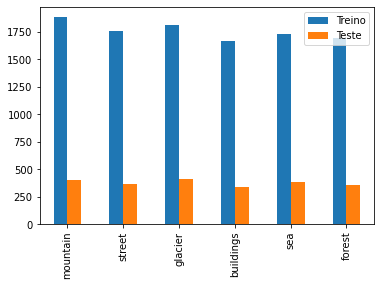

In [ ]:
# Verificando proporção entre treino e teste de cada classe dos dados
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'Treino': train_counts,
              'Teste': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

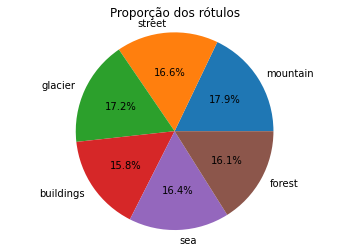

In [ ]:
# Proporção de cada rótulo em relação ao dataset de treino
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporção dos rótulos')
plt.show()

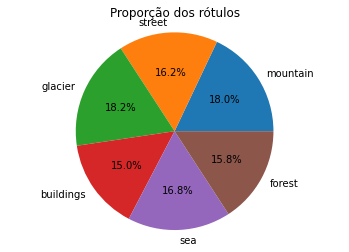

In [ ]:
# Proporção de cada rótulo em relação ao dataset de teste
plt.pie(test_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proporção dos rótulos')
plt.show()

# Visualizando alguns exemplos

Continuando a exploração do dataset exibiu-se alguns exemplos.

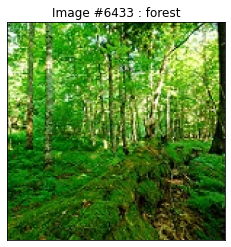

In [ ]:
# Visualização Aleatória
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

display_random_image(class_names, train_images, train_labels)

In [ ]:
# Visualização em grupo
def display_examples(class_names, images, labels, n = 10):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Exemplos do dataset", fontsize=16)
    for i in range(n):
        plt.subplot(int(n/5) + 1, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

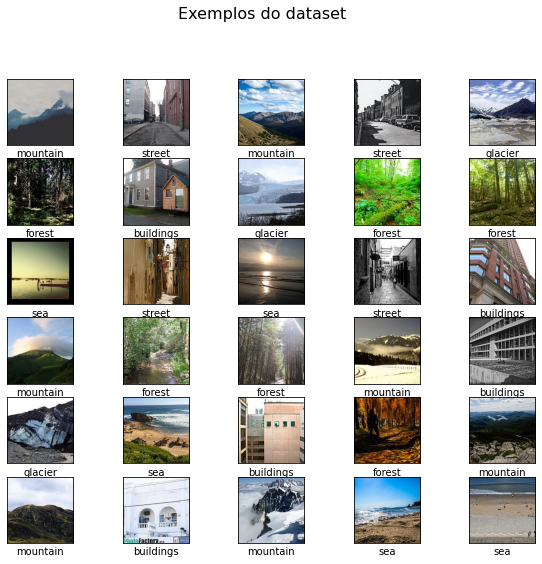

In [ ]:
display_examples(class_names, train_images, train_labels, 30)

#Criação do Modelo

O modelo de classificação utilizado foi um CNN da biblioteca _Keras_. A convolução é feita por 32 filtros 2D de tamanhos 3x3, nos quais serão extraídos os atributos das imagens, e a condição de ativação escolhida foi o _ReLU_. Em seguida, é chamado um _MaxPooling2D_ para reduzir a dimensão das saídas das convoluções pegando apenas o valor máximo numa janela de tamanho 2x2. Esses passos são repetidos mais uma vez e o formato do resultado é redimensionado para um array 1D.

As imagens então são enviadas para a primeira camada escondida com ativação _ReLU_ e saída de tamanho 128 e repassadas para a última camada, de classificação, que aplica um _softmax_ para decidir qual neurônio será ativado, dos 6 que representam cada classe.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

A compilação do modelo foi otimizada com o parâmetro "adam", que consiste em um método estocástico de descida do gradiente, e a função de erro para limitar a classificação a apenas uma classe, usando cálculos probabilísticos.

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Executando 20 épocas nos conjuntos de treinamento e calculando as métricas de acurácia e erro do treinamento e validação
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
66/66 [==============================] - 18s 92ms/step - loss: 1.1830 - accuracy: 0.5477 - val_loss: 0.8098 - val_accuracy: 0.7056
Epoch 2/20
66/66 [==============================] - 4s 63ms/step - loss: 0.7442 - accuracy: 0.7230 - val_loss: 0.7325 - val_accuracy: 0.7369
Epoch 3/20
66/66 [==============================] - 4s 67ms/step - loss: 0.5693 - accuracy: 0.7976 - val_loss: 0.6532 - val_accuracy: 0.7669
Epoch 4/20
66/66 [==============================] - 4s 62ms/step - loss: 0.4323 - accuracy: 0.8572 - val_loss: 0.6205 - val_accuracy: 0.7849
Epoch 5/20
66/66 [==============================] - 4s 65ms/step - loss: 0.3006 - accuracy: 0.9056 - val_loss: 0.7025 - val_accuracy: 0.7602
Epoch 6/20
66/66 [==============================] - 5s 69ms/step - loss: 0.2156 - accuracy: 0.9352 - val_loss: 0.7116 - val_accuracy: 0.7759
Epoch 7/20
66/66 [==============================] - 4s 62ms/step - loss: 0.1392 - accuracy: 0.9591 - val_loss: 0.7687 - val_accuracy: 0.7953
Epoch 8/20
6

# Análise da Acurácia

In [ ]:
def plot_accuracy_loss(history):
    """
        Funcao para plotagem de acuracia e erro.
    """
    fig = plt.figure(figsize=(15,8))

    # Plot da acuracia
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acuracia")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acuracia")
    plt.title("Acurácia do Treino vs Acurácia da Validação")
    plt.ylabel("acuracia")
    plt.xlabel("epocas")
    plt.legend()

    # Plot da funcao de erro
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "erro")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_erro")
    plt.title("Erro do Treino vs Erro da Validação")
    plt.ylabel("erro")
    plt.xlabel("epocas")

    plt.legend()
    plt.show()

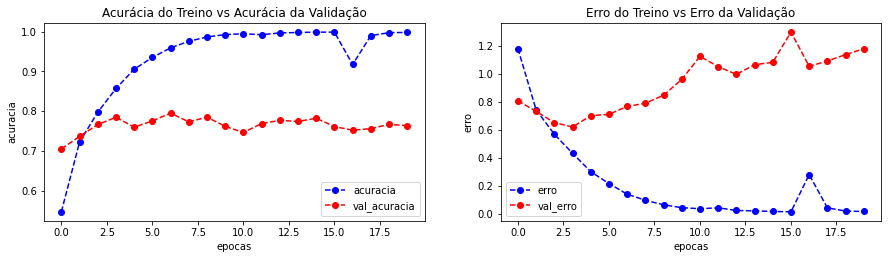

In [ ]:
plot_accuracy_loss(history)

No gráfico acima podemos perceber que o conjunto de treinamento demonstra um comportamento promissor quanto a acurácia e erro, porém isso não é visto no conjunto de validação. A acurácia da validação converge entre os valores 0.7 e 0.8, enquanto que o erro apresenta um crescimento com o passar das épocas, o que pode significar que o modelo está sofrendo de _overfitting_ durante o treinamento.

In [ ]:
# Avaliando o erro no conjunto de teste
test_loss = model.evaluate(test_images, test_labels)

71/71 [==============================] - 1s 9ms/step - loss: 1.3224 - accuracy: 0.7422


Dado o resultado acima, feito no conjunto de testes, podemos concluir que, pelo fato do modelo estar um pouco "viciado", a acurácia não foi tão elevada.

Abaixo é executado um exemplo de classificação de uma imagem do conjunto de teste.

71/71 [==============================] - 1s 7ms/step


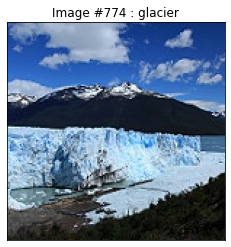

In [ ]:
predictions = model.predict(test_images)     # vetor de probabilidades
pred_labels = np.argmax(predictions, axis = 1) # selecao da probabilidade mais alta que indica a classe

display_random_image(class_names, test_images, pred_labels)

## Análise de Erro

Como a acurácia final atingida ficou na faixa de 70%, é interessante analisar os erros encontrados em busca de um padrão nas imagens que possa explicar em quais situações o classificador encontrou mais dificuldades para atribuir os rótulos corretos.

Observando a matriz de confusão é possível encontrar os tipos de imagem que causaram mais erros no classificador.
A primeira grande causa de confusão que pode ser notada são entres as imagens dos tipos "glacier", "mountain" e "sea" o que pode ser explicado pela intersecção de características nessas imagens. Por exemplo, é muito comum que em imagens de montanhas ou lugares glaciais existam também mares ou rios, portanto, é experado que isso causa certa confusão ao classificador.
A segunda causa de confusão deriva do mesmo tipo de problema, a intersecção, mas nesse caso nas imagens dos tipos "street" e "buildings" onde é muito comum haver ao mesmo tempo construções e ruas nas mesmas imagens.

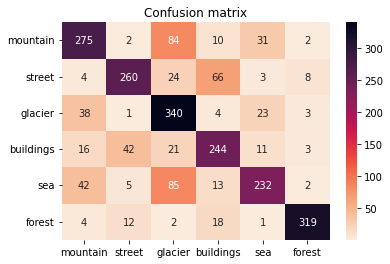

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           annot_kws={"size": 10}, fmt='d', cmap='rocket_r',
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [ ]:
print(classification_report(test_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

    mountain       0.73      0.68      0.70       404
      street       0.81      0.71      0.76       365
     glacier       0.61      0.83      0.70       409
   buildings       0.69      0.72      0.71       337
         sea       0.77      0.61      0.68       379
      forest       0.95      0.90      0.92       356

    accuracy                           0.74      2250
   macro avg       0.76      0.74      0.75      2250
weighted avg       0.75      0.74      0.74      2250



## Conclusão
Dado a matriz de confusáo e as métricas calculadas foi possível perceber que a rede neural teve um otimo desempenho em classificar florestas, mas deixou a deixar na classificação de prédios e geleiras.

Tal comportamento pode ser devido ao fato de floresta possuirem uma coloração verde bem forte e marcante, se distinguindo das demais imagens com facilidade. Por outro lado, prédios possuem vários pixels em preto ou em escala de cinza, o que é facilmente encontrado nas demais imagens. Geleiras por sua vez possuem muitos pixels brancos o que é facilmente encontrado nas outras imagens, principalmente montanhas, como por exemplo, montanhas que possuem seu cume com neve.

Embora não tenha atingido valores muito elevados na acurácia final, a implementação de classificação das imagens através de Redes Neurais Convolucionais ainda se mostra relativamente interessante. Principalmente compreendendo quais foram os conjuntos de imagens que mais causaram dificuldades, é possível estudar meios para melhorias e consequentemente um maior aproveitamento dos resultados obtidos.

Uma possível maneira de se atingir melhores resultados seria através da combinação com mais outros modelos de classificação, no entanto, não foi possível realizar os testes necessários por conta das limitações de memória presentes nos ambientes disponíveis. Ademais, é possível analisar um uso de classificação multiórulo visando resolver o problema de imagens que podem ter mais de um rótulo como é o caso de geleiras e montanhas.